In [194]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import splitfolders
import zipfile
import random
import os
from keras.preprocessing.image import ImageDataGenerator
from scipy import misc

In [195]:
# Load datasets
local_zip = 'rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp')
zip_ref.close()

In [196]:
# Split the dataset into training, validation, and test sets
splitfolders.ratio('tmp\\rps', output="tmp\\rps\\rockpaperscissors", seed=1337, ratio=(0.7, 0.25, 0.05))

In [197]:
# Define the directory paths
data_dir = 'tmp\\rps\\rockpaperscissors'
training_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Print the number of samples in each class
print("Number of folder in training set:", len(os.listdir(os.path.join(training_dir))))
print("Number of rock samples in training set:", len(os.listdir(os.path.join(training_dir, 'rock'))))
print("Number of paper samples in training set:", len(os.listdir(os.path.join(training_dir, 'paper'))))
print("Number of scissors samples in training set:", len(os.listdir(os.path.join(training_dir, 'scissors'))))

print("\nNumber of folder in validation set:", len(os.listdir(os.path.join(validation_dir))))
print("Number of rock samples in training set:", len(os.listdir(os.path.join(validation_dir, 'rock'))))
print("Number of paper samples in training set:", len(os.listdir(os.path.join(validation_dir, 'paper'))))
print("Number of scissors samples in training set:", len(os.listdir(os.path.join(validation_dir, 'scissors'))))

print("\nNumber of folder in test set:", len(os.listdir(os.path.join(test_dir))))
print("Number of rock samples in training set:", len(os.listdir(os.path.join(test_dir, 'rock'))))
print("Number of paper samples in training set:", len(os.listdir(os.path.join(test_dir, 'paper'))))
print("Number of scissors samples in training set:", len(os.listdir(os.path.join(test_dir, 'scissors'))))

Number of folder in training set: 3
Number of rock samples in training set: 588
Number of paper samples in training set: 588
Number of scissors samples in training set: 588

Number of folder in validation set: 3
Number of rock samples in training set: 210
Number of paper samples in training set: 210
Number of scissors samples in training set: 210

Number of folder in test set: 3
Number of rock samples in training set: 42
Number of paper samples in training set: 42
Number of scissors samples in training set: 42


In [198]:
training_paper_dir = os.path.join(training_dir, 'paper')
training_rock_dir = os.path.join(training_dir, 'rock')
training_scissors_dir = os.path.join(training_dir, 'scissors')

validation_paper_dir = os.path.join(validation_dir, 'paper')
validation_rock_dir = os.path.join(validation_dir, 'rock')
validation_scissors_dir = os.path.join(validation_dir, 'scissors')

test_paper_dir = os.path.join(test_dir, 'paper')
test_rock_dir = os.path.join(test_dir, 'rock')
test_scissors_dir = os.path.join(test_dir, 'scissors')



In [199]:
paper_imgs = os.listdir(training_paper_dir)
rock_imgs = os.listdir(training_rock_dir)
scissors_imgs = os.listdir(training_scissors_dir)

In [200]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.5,
    zoom_range=0.2, 
    rotation_range=20, 
    horizontal_flip=True 
)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [201]:
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(150,150),
    classes=['paper', 'rock', 'scissors'],
    batch_size = 32,
    class_mode='categorical',
    shuffle=False
)

valid_generator= validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    classes=['paper', 'rock', 'scissors'],
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    classes=['paper','rock', 'scissors'],
    shuffle=False
)

Found 1764 images belonging to 3 classes.
Found 315 images belonging to 3 classes.
Found 126 images belonging to 3 classes.


In [202]:
from tensorflow.keras.applications import MobileNetV2

# Ganti ResNet101 dengan MobileNetV2
baseModel = MobileNetV2(
    weights="imagenet",
    input_tensor=Input(shape=(150, 150, 3)),
    include_top=False,
    )

In [203]:
# Model Summary
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_8[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

In [204]:
# Freeze the baseModel karena sudah dilakukan training
baseModel.trainable = False

In [205]:
# Creating Fully Connected
x = baseModel.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)  # Regularize with dropout
outputs = Dense(3, activation='softmax')(x)  # Menggunakan softmax untuk output kelas yang lebih dari dua
model = Model(inputs=baseModel.input, outputs=outputs)

In [206]:
# Model Summary yang kita buat
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_8[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

In [207]:
# Complie Model
from tensorflow.keras.optimizers import Adam

model.compile(Adam(lr=.001), loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\Bachtiar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [208]:
# training Transfer Learning Model ResNet101
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
)

Epoch 1/10
56/56 [==============================] - 17s 282ms/step - loss: 8.7579 - accuracy: 0.6463 - val_loss: 0.3159 - val_accuracy: 0.9143
Epoch 2/10
56/56 [==============================] - 7s 130ms/step - loss: 0.3665 - accuracy: 0.8713 - val_loss: 0.1772 - val_accuracy: 0.9333
Epoch 3/10
56/56 [==============================] - 7s 129ms/step - loss: 0.2792 - accuracy: 0.9240 - val_loss: 0.0381 - val_accuracy: 0.9937
Epoch 4/10
56/56 [==============================] - 7s 128ms/step - loss: 0.1313 - accuracy: 0.9700 - val_loss: 0.0254 - val_accuracy: 1.0000
Epoch 5/10
56/56 [==============================] - 7s 127ms/step - loss: 0.0858 - accuracy: 0.9779 - val_loss: 0.0147 - val_accuracy: 0.9968
Epoch 6/10
56/56 [==============================] - 7s 127ms/step - loss: 0.0587 - accuracy: 0.9870 - val_loss: 0.0142 - val_accuracy: 0.9968
Epoch 7/10
56/56 [==============================] - 7s 130ms/step - loss: 0.0423 - accuracy: 0.9921 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch

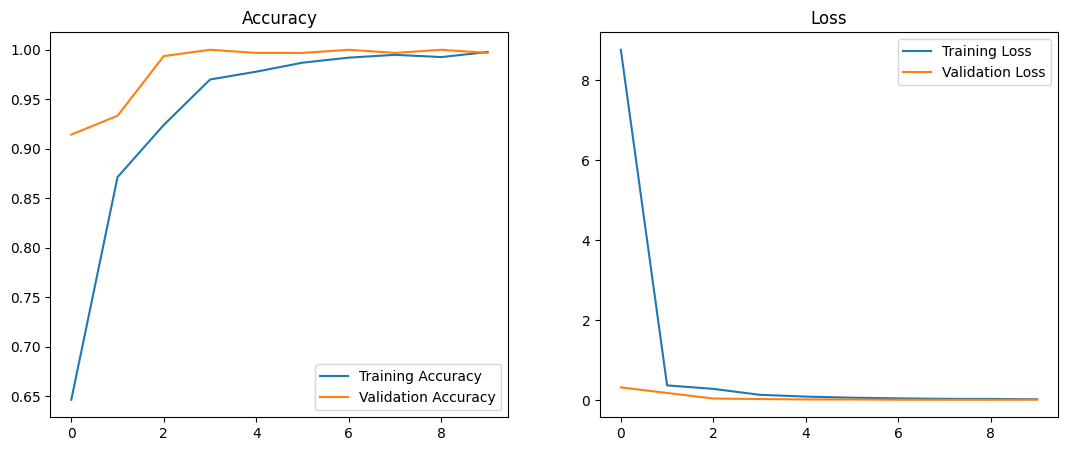

In [209]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [210]:
# Printout Accuracy and Loss
loss, accuracy = model.evaluate(test_generator)
print("Validation: \nAccuracy = %f  \nLoss = %f " % (accuracy, loss))

4/4 [==============================] - 1s 186ms/step - loss: 0.0052 - accuracy: 1.0000
Validation: 
Accuracy = 1.000000  
Loss = 0.005234 


In [211]:
# Showing Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predictting Model
y_pred =  model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
target_names = ['paper', 'rock', 'scissors']  # Sesuaikan dengan kelas yang ada dalam model Anda

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))


4/4 [==============================] - 1s 56ms/step
Classification Report
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00        42
        rock       1.00      1.00      1.00        42
    scissors       1.00      1.00      1.00        42

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



In [212]:
model.save('model.h5')

1/1 [==============================] - 0s 16ms/step


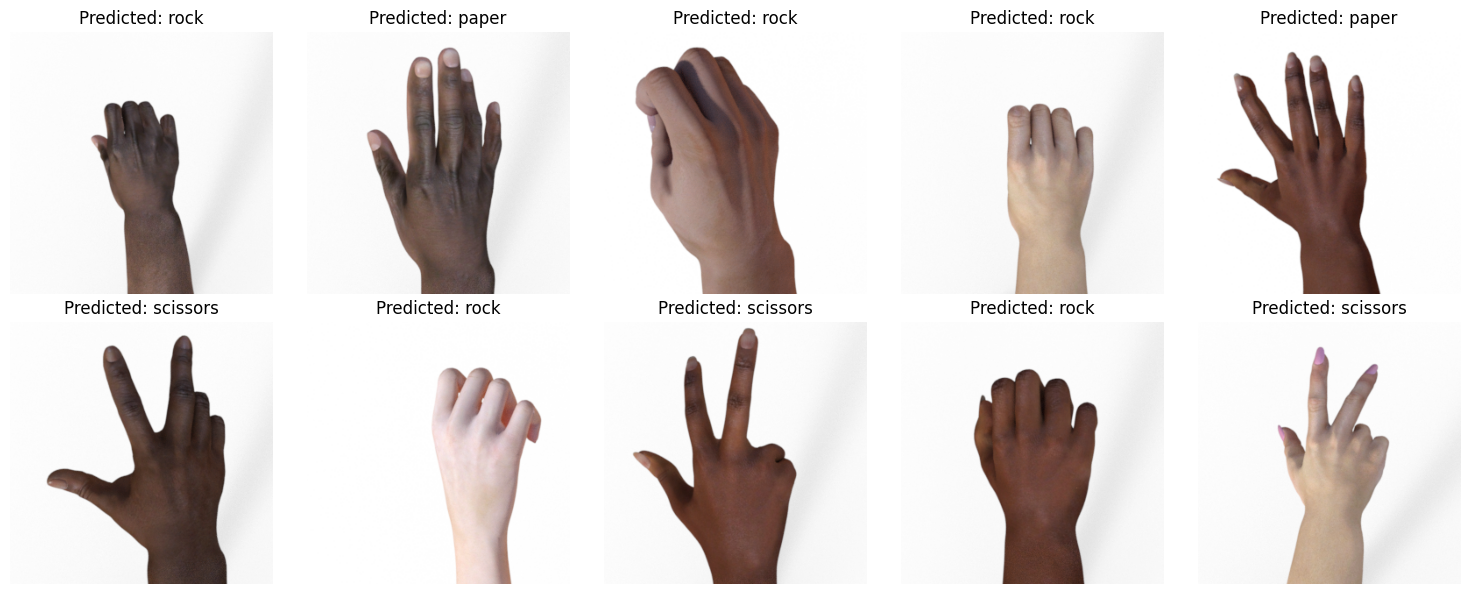

In [218]:
import os
import random
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
loaded_model = load_model('model.h5')

# List all subdirectories in the test directory
subdirs = ['paper', 'rock', 'scissors']

# Initialize an empty list to store paths to all images
all_images = [os.path.join(test_dir, subdir, img) for subdir in subdirs for img in os.listdir(os.path.join(test_dir, subdir))]

# Shuffle the list of all images
random.shuffle(all_images)

# Display 10 random images with predictions
plt.figure(figsize=(15, 6))
for i, image_path in enumerate(all_images[:10]):
    # Read and process the image
    img_array = img_to_array(load_img(image_path, target_size=(150, 150))) / 255.0  # Normalize

    # Make a prediction using the loaded model
    prediction = loaded_model.predict(np.expand_dims(img_array, axis=0))

    # Display the image and prediction result
    predicted_label = subdirs[np.argmax(prediction)]

    plt.subplot(2, 5, i + 1)
    plt.imshow(load_img(image_path))
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()